Bibliotecas:

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

import warnings
warnings.filterwarnings('ignore')

Para evitar erros na execução, os dois blocos de código a seguir fazem uma verificação nos dados! Excluindo qualquer arquivo de voo onde não existam dados com IAS maior que 40.

In [2]:
# Sobre os dados na pasta 'data_SWUQ'

for file_name in os.listdir('data_SWUQ'):
    file_path = os.path.join('data_SWUQ', file_name)

    try:
        df = pd.read_csv(file_path, encoding='latin', skiprows=2)
        df['    IAS'] = pd.to_numeric(df['    IAS'], errors='coerce')
        df = df[df['    IAS'] > 40]

        if df.empty:
            print(f'Arquivo {file_path} não contém nenhuma entrada com IAS > 40 e será removido')
            os.remove(file_path)
    except Exception as e:
        print(e)

In [3]:
# Sobre os dados na pasta 'data_SBBV'

for file_name in os.listdir('data_SBBV'):
    file_path = os.path.join('data_SBBV', file_name)

    try:
        df = pd.read_csv(file_path, encoding='latin', skiprows=2)
        df['    IAS'] = pd.to_numeric(df['    IAS'], errors='coerce')
        df = df[df['    IAS'] > 40]

        if df.empty:
            print(f'Arquivo {file_path} não contém nenhuma entrada com IAS > 40 e será removido')
            os.remove(file_path)
    except Exception as e:
        print(e)

* Definições iniciais

O bloco abaixo faz algumas definições iniciais sobre os tipos de dados e criação de algumas listas que serão usadas mais adiante.

In [4]:
# Carregando o dataset
df = pd.read_csv('data/voo.csv', encoding='latin', skiprows=2)
df.dropna(inplace=True)

Lista de Colunas:

In [5]:
df.columns

Index(['  Lcl Date', ' Lcl Time', ' UTCOfst', ' AtvWpt', '     Latitude',
       '    Longitude', '    AltB', ' BaroA', '  AltMSL', '   OAT', '    IAS',
       ' GndSpd', '    VSpd', '  Pitch', '   Roll', '  LatAc', ' NormAc',
       '   HDG', '   TRK', ' volt1', '  amp1', '  FQtyL', '  FQtyR',
       ' E1 FFlow', ' E1 OilT', ' E1 OilP', ' E1 Torq', '   E1 NP', '   E1 NG',
       '  E1 ITT', '  AltGPS', ' TAS', ' HSIS', '    CRS', '   NAV1',
       '   NAV2', '    COM1', '    COM2', '   HCDI', '   VCDI', ' WndSpd',
       ' WndDr', ' WptDst', ' WptBrg', ' MagVar', ' AfcsOn', ' RollM',
       ' PitchM', ' RollC', ' PichC', ' VSpdG', ' GPSfix', '  HAL', '   VAL',
       ' HPLwas', ' HPLfd', ' VPLwas'],
      dtype='object')

Lista de colunas para remover da análise:

In [6]:
remove = ['     Latitude', '    Longitude', '   NAV1', '   NAV2', '    COM1', '    COM2']

# Não remover as colunas relacionadas com tempo****

Dados com as colunas excluídas

In [7]:
df.drop(columns=remove, inplace=True)

In [8]:
# Separando dados numéricos de dados categóricos
dados_categorica = df.select_dtypes('object')
dados_numerica = df.select_dtypes(exclude='object')
list_cat = list(dados_categorica.columns)
list_num = list(dados_numerica.columns)

# Dataframe com dados numéricos
df_num = df[list_num]

# Metadados com tipos de dado e número de valores únicos
meta = pd.DataFrame({'dtypes': df_num.dtypes})
meta['nunique'] = df_num.nunique()

# Listas com colunas para transformações futuras
col_bin = list(meta[meta['nunique'] < 20].index)
col_num = [item for item in list_num if item not in col_bin]

# Array com os nomes das colunas
colunas = df.columns

## Decolagem

A seguinte função faz um preprocessamento básico junto com um filtro para definir os dados relacionados a decolagem

In [9]:
def preprocessamento_deco(file_path):
    ''' A função recebe o caminho de um arquivo de voo e retorna um dataframe preprocessado
        para utilizações futuras'''

    df = pd.read_csv(file_path, encoding='latin', skiprows=2)
    df.drop(columns=remove, inplace=True)
    df = df.replace(r'^\s*$', 0, regex=True) # Substitui espaços em branco por 0
    df = df.replace('  -', np.nan) # Substitui caracter invalido por nulo
    df = df.interpolate(method='linear', limit_direction='forward', axis=0).fillna(0) # Interpolação para preencher nulos  
    
    # Filtro para capturar apenas os dados relacionados a decolagem
    df['    IAS'] = pd.to_numeric(df['    IAS'], errors='coerce')
    df = df[df['    IAS'] > 40]
    
    return df

In [10]:
# Teste da função:

teste = preprocessamento_deco('data/log_230419_121247_SBBV.csv')

# Expondo as primeiras 5 linhas:
teste.head()

Lcl Date   Lcl Time   UTCOfst   AtvWpt      AltB   BaroA    AltMSL  \
489  2023-04-19   12:20:58    -05:00     SWUQ     374.5   29.94     273.1   
490  2023-04-19   12:20:59    -05:00     SWUQ     373.5   29.94     273.2   
491  2023-04-19   12:21:00    -05:00     SWUQ     375.5   29.94     273.7   
492  2023-04-19   12:21:01    -05:00     SWUQ     374.5   29.94     274.0   
493  2023-04-19   12:21:02    -05:00     SWUQ     373.5   29.94     274.1   

        OAT      IAS   GndSpd  ...   PitchM   RollC   PichC   VSpdG   GPSfix  \
489    38.0    43.50    41.11  ...       TO     0.0     7.0    31.5       3D   
490    38.0    47.43    44.14  ...       TO     0.0     7.0    23.6       3D   
491    37.8    51.23    47.10  ...       TO     0.0     7.0    23.6       3D   
492    37.8    54.85    49.98  ...       TO     0.0     7.0    11.8       3D   
493    37.8    57.26    52.83  ...       TO     0.0     7.0     3.9       3D   

        HAL     VAL   HPLwas   HPLfd   VPLwas  
489  1852.0     0.0      0.0    85.5      0.0  
490  1852.0     0.0      0.0    85.5      0.0  
491  1852.0     0.0      0.0    85.5      0.0  
492  1852.0     0.0      0.0    85.5      0.0  
493  1852.0     0.0      0.0    85.5      0.0  

[5 rows x 51 columns]

A próxima função é uma pipeline de dados com os seguintes passos:

* Carregar os dados preprocessados
* Aplica uma transformação de padronização dos dados numéricos com mais de 20 valores únicos
* Aplica uma binarização dos dados numéricos com menos de 20 valores únicos
* Cria a coluna 'time' que tem o tempo resetado, para selecionar períodos específicos do voo
* Reamostragem de dados para cada 30 segundos
* Vetorização do dataframe

In [11]:
def pipe_deco(file_path):
    ''' Recebe um caminho de arquivo, realiza as operações descritas acima e retorna um 
        vetor contendo as informções do arquivo e o nome do arquivo'''

    # Carregando dados preprocessados
    df = preprocessamento_deco(file_path)
    
    # Padronização
    scaler = StandardScaler()
    df[col_num] = scaler.fit_transform(df[col_num])

    # Binarização
    encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    encoded_features = encoder.fit_transform(df[col_bin].astype(str))
    encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(col_bin))
    df = pd.concat([df.reset_index(drop=True), encoded_df.reset_index(drop=True)], axis=1).drop(col_bin, axis=1)

    # Criação da coluna 'time' e resample
    sample_interval = '30'
    tempo = pd.to_datetime(df['  Lcl Date'] + ' ' + df[' Lcl Time'].str.slice(0, 5), 
                           format='%Y-%m-%d %H:%M', errors='coerce')
    tempo = tempo.dropna()
    df = df.select_dtypes('number')
    df['time'] = tempo
    df = df.set_index('time').resample(f'{sample_interval}S').mean().fillna(method='ffill').dropna().reset_index()
    df['time'] = df['time'] - df['time'].iloc[0]
    
    # Selecionando apenas os dados com tempo menor que 10 minutos
    df = df[df['time'] <= pd.Timedelta(minutes=10)]

    # Vetorização do dataframe
    vetor = df.drop(columns=['time']).values.flatten()

    return vetor, file_path, df

In [12]:
# Teste da função

teste, nome, df_teste = pipe_deco('data/log_230419_121247_SBBV.csv')

print(f'Nome do voo: {nome}\nVetor:{teste}')

Nome do voo: data/log_230419_121247_SBBV.csv
Vetor:[-1.9569876  -1.94199825  2.3518966  ...  0.          1.
  0.        ]


A função a seguir realiza a clusterização e armazana os resultados com os seguintes passos:

* Aplica a função anterior em todos os arquivos na pasta 'data'
* Cria um dataframe onde cada linha representa as informações de um voo
* Realiza um PCA sobre este dataframe
* Clusterização usando o algoritmo DBSCAN
* Agrega ao dataframe transformado o resultado do cluster e o nome do arquivo

In [13]:
def cluster_deco(data_dir):
    ''' Recebe o nome da pasta na qual os arquivos estão armazenados e retorna um dataframe
        com as componentes principais do PCA, resultado do cluster e nome do arquivo'''
    
    # Criando listas para armazenar os vetores e nomes de arquivos
    vetores = []
    files = []

    # Aplica a função anterior e armazena os resultados para todos os arquivos
    for file_name in os.listdir(data_dir):
        if file_name.endswith('.csv'):
            file_path = os.path.join(data_dir, file_name)
            vetor, file, _ = pipe_deco(file_path)
            if vetor is not None:
                vetores.append(vetor)
                files.append(file)

    # Contruindo um dataframe com os vetores de todos os arquivos e seus respectivos nomes
    df = pd.DataFrame(vetores)
    df['file'] = files

    # Remoção de valores nulos e junção do nome do arquivo
    df_final = df
    df_final = df_final.dropna(axis=1, how='all')
    df_final.fillna(0, inplace=True)
    df_final['file'] = files

    return df_final

* PCA: PCA é uma tecnica de redução de dimensionalidade. O dataframe contruido com os vetores da função 'pipe_deco' contém centenas de colunas. O PCA realiza uma combinação linear de todas estas variveis e as armazena em componentes principais. O resultado disso é que com poucas componentes é possível explicar a maior parte da variabilidade dos dados, reduzindo assim a dimensão do dataframe ao custo de perda de uma pequena parte da informação. O número de componentes do PCA é escolhido no parâmetro 'n_components'.

* DBSCAN: É um algoritmo de clusterização baseado em densidade de pontos, A escolha de múmero de clusters é automática e não existe restrições de tamanhos de clusters, auxiliando na detecção de outliers. O parâmetro mais relevante para este algoritmo é o 'eps' que define a vizinhança em torno de um ponto para caracterizar um grupo.

#### PCA e Clusterização

In [14]:
# Armazenando o resultado da clusterização na variável df_final

df_final = cluster_deco('data_SBBV')

Abaixo existe um código para verificar a explicabilidade das componentes do PCA:

In [15]:
pca = PCA().fit(df_final.drop(columns=['file']))

# Verificando a explicabilidade do PCA em função do número de componentes:
for i in range(1,30):
    print(f'n_comp {i}: {pca.explained_variance_ratio_[:i].sum()}')

n_comp 1: 0.40984168722933323
n_comp 2: 0.5524667691812982
n_comp 3: 0.6811113617466344
n_comp 4: 0.7556973438455931
n_comp 5: 0.817039432114538
n_comp 6: 0.856919487232479
n_comp 7: 0.8851925440361434
n_comp 8: 0.9121353311533507
n_comp 9: 0.935903794240212
n_comp 10: 0.9541538088575816
n_comp 11: 0.9705040899367845
n_comp 12: 0.9756767156802292
n_comp 13: 0.9795360970713068
n_comp 14: 0.9819302431101339
n_comp 15: 0.9840551654158459
n_comp 16: 0.986092910723383
n_comp 17: 0.9880223072338717
n_comp 18: 0.9898321465480361
n_comp 19: 0.9914508343947923
n_comp 20: 0.9928167135236233
n_comp 21: 0.993776189620234
n_comp 22: 0.994581231527266
n_comp 23: 0.9953305163647849
n_comp 24: 0.9959909235212366
n_comp 25: 0.9966394774996991
n_comp 26: 0.99720236745895
n_comp 27: 0.9976560247377777
n_comp 28: 0.9980777292535665
n_comp 29: 0.9984618337958125


Importante ressaltar que, por definição, o algoritmo DBSCAN não lida muito bem com alta dimensionalidade, então é interessante manter um número de componentes relativamente baixo (menor que 15 por exemplo). Segundo o artigo, as PCAs feitas conseguiam explicar cerca de 90% dos dados.

In [16]:
# Criando um PCA com o número de componentes desejado

df_pca = PCA(n_components=8).fit_transform(df_final.drop(columns=['file']))

In [17]:
# Visualizando o PCA

pd.DataFrame(df_pca)

0          1          2          3          4          5  \
0   -638.034722 -29.334424  10.742868  11.748993  -5.928527 -24.820233   
1   -638.208941 -47.562127  -0.874762   4.926076   0.898887  35.283870   
2   -638.077100 -29.902759  11.821776   9.378676  -4.010267 -25.411278   
3   -639.538969 -32.710588  11.807306  10.799491  -5.107583 -27.059574   
4   -634.232667  -4.377106  35.754415  13.616955  -5.852143 -35.272713   
..          ...        ...        ...        ...        ...        ...   
217 -646.757350 -32.284722  18.628477  43.100579  50.756001  55.995999   
218 -637.653065 -30.252868  11.688861  10.129146  -3.166864 -26.595483   
219 -637.511122 -30.320059  11.484950   9.951427  -3.304200 -26.464333   
220 -637.654099 -29.988118  11.635897  10.312606  -4.199278 -25.693188   
221 -638.026458 -30.050383  12.052614  10.435404  -4.271056 -26.228974   

              6           7  
0      5.294738  -31.967037  
1   -123.404911 -110.894745  
2      5.274519  -33.279982  
3      2.923967  -31.725579  
4      6.199430  -31.845251  
..          ...         ...  
217    4.466642  121.022246  
218    5.289150  -32.606533  
219    4.680625  -33.249920  
220    5.031503  -33.447949  
221    4.386625  -32.693280  

[222 rows x 8 columns]

Criando listas com os valores de 'eps' e os respectivos percentuais de voos anormais e porcentagens para analisar o comportamento do cluster.

In [18]:
min_samples = 5

# listas:
epss = []
pcts = []
nums = []

# Iterando sobre os valores de eps no range definido
for eps in np.arange(5, 501, 2):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    resultado = dbscan.fit_predict(df_pca)
    resultado[resultado != 0] = -1
    pct = (np.count_nonzero(resultado == -1)/len(resultado))*100
    num = np.count_nonzero(resultado == -1)
    
    if len(set(resultado)) > 1:
        score = silhouette_score(df_pca, resultado) # Silhouette score é uma métrica para avaliar qualidade de cluster
        nums.append(num)
        epss.append(eps)
        pcts.append(pct)
        #print(f'eps: {eps}, voo anormal: {round(pct,2)}%, Silhouette Score: {score}')

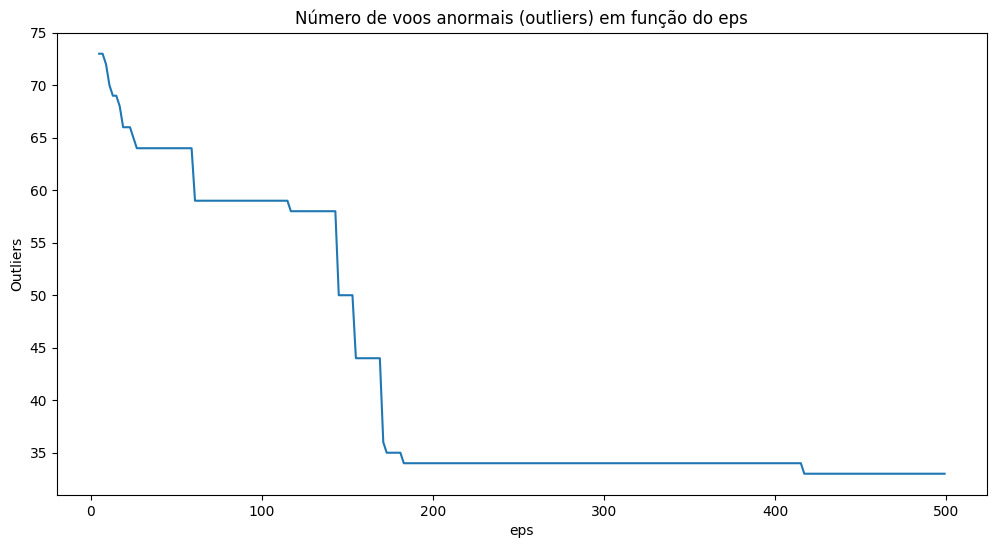

In [19]:
plt.figure(figsize=(12,6))
plt.title('Número de voos anormais (outliers) em função do eps')
sns.lineplot(x=epss, y=nums)
plt.ylabel('Outliers')
plt.xlabel('eps')
plt.show()

O gráfico acima explica como o aumento do 'eps' reduz o número de voos que o algoritmo entende como anormais. Ao aumentar o eps você agrupa voos mais 'distantes' no grupo principal.

In [20]:
# Tabela com os resultados

eps_outliers = pd.DataFrame()
eps_outliers['eps'] = epss
eps_outliers['pct_outliers'] = pcts
eps_outliers['pct_outliers'] = eps_outliers['pct_outliers'].apply(lambda x: round(x,2))
eps_outliers['num_outliers'] = nums

eps_outliers

eps  pct_outliers  num_outliers
0      5         32.88            73
1      7         32.88            73
2      9         32.43            72
3     11         31.53            70
4     13         31.08            69
..   ...           ...           ...
243  491         14.86            33
244  493         14.86            33
245  495         14.86            33
246  497         14.86            33
247  499         14.86            33

[248 rows x 3 columns]

In [21]:
# Realizando um cluster com o eps desejado

cluster = DBSCAN(eps=300, min_samples=5).fit(df_pca)

In [22]:
# Dataframe com o resultado do cluster e o nome do arquivo

resultados_deco = pd.DataFrame(df_pca)
resultados_deco['cluster_deco'] = cluster.labels_
resultados_deco['cluster_deco'] = resultados_deco['cluster_deco'].apply(lambda x: 0 if x==0 else -1)
resultados_deco['file'] = df_final['file']

resultados_deco.head()

0          1          2          3         4          5  \
0 -638.034722 -29.334424  10.742868  11.748993 -5.928527 -24.820233   
1 -638.208941 -47.562127  -0.874762   4.926076  0.898887  35.283870   
2 -638.077100 -29.902759  11.821776   9.378676 -4.010267 -25.411278   
3 -639.538969 -32.710588  11.807306  10.799491 -5.107583 -27.059574   
4 -634.232667  -4.377106  35.754415  13.616955 -5.852143 -35.272713   

            6           7  cluster_deco                                  file  
0    5.294738  -31.967037             0  data_SBBV\log_230419_121247_SBBV.csv  
1 -123.404911 -110.894745             0  data_SBBV\log_230420_062111_SBBV.csv  
2    5.274519  -33.279982             0  data_SBBV\log_230420_114021_SBBV.csv  
3    2.923967  -31.725579             0  data_SBBV\log_230421_104535_SBBV.csv  
4    6.199430  -31.845251             0  data_SBBV\log_230424_111940_SBBV.csv

Comparando a correlação entre as variáveis dos voos antes e depois do PCA:

In [23]:
corr1 = df_final.drop(columns=['file']).corr(method='spearman')
corr2 = resultados_deco.drop(columns=['cluster_deco', 'file']).corr(method='spearman')

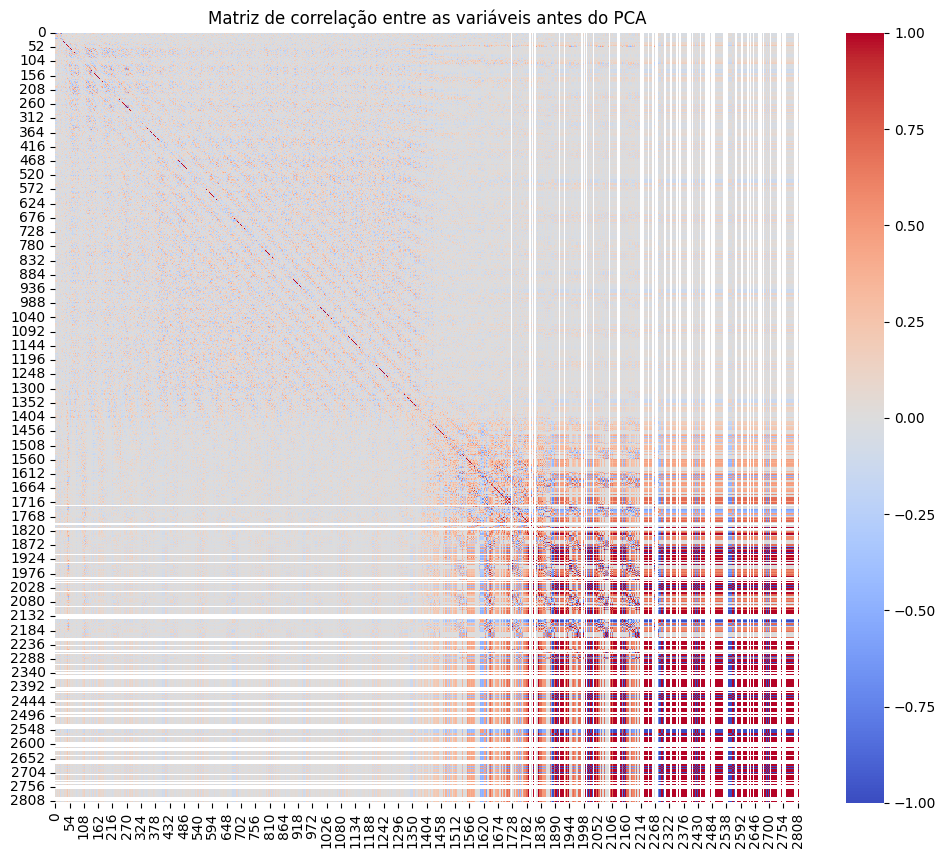

In [24]:
plt.figure(figsize=(12,10))
sns.heatmap(corr1, cmap='coolwarm')
plt.title('Matriz de correlação entre as variáveis antes do PCA')
plt.show()

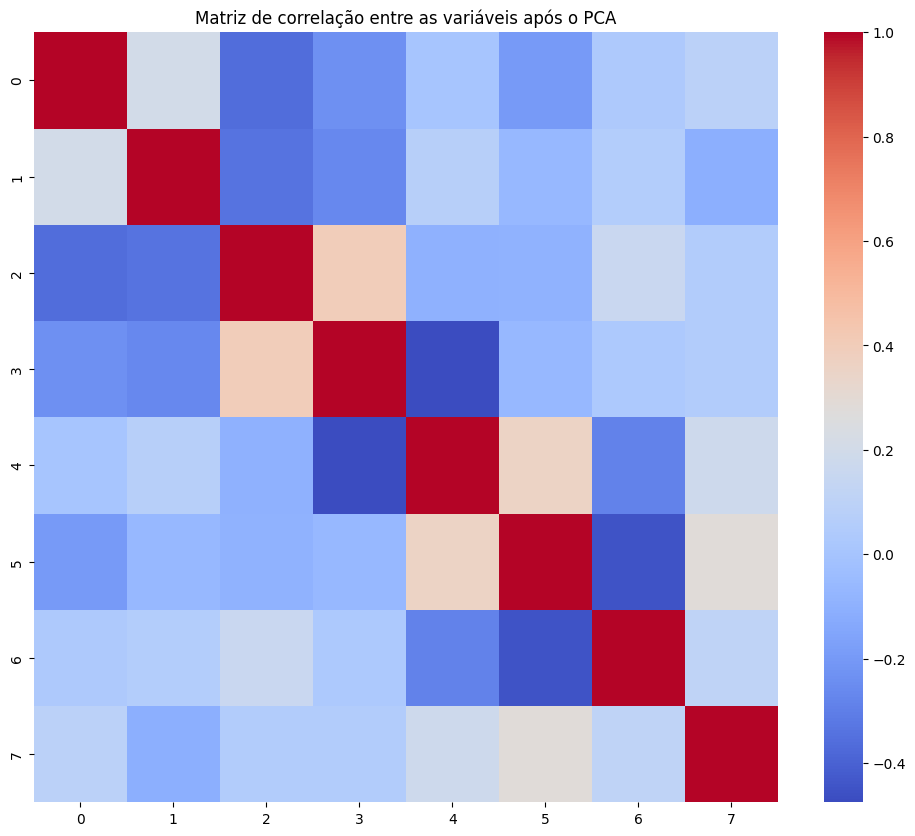

In [25]:
plt.figure(figsize=(12,10))
sns.heatmap(corr2, cmap='coolwarm')
plt.title('Matriz de correlação entre as variáveis após o PCA')
plt.show()

In [26]:
# Dicionário que associa o nome do arquivo e o resultado do cluster

dict_resultado_deco = resultados_deco[['file', 'cluster_deco']].set_index('file')['cluster_deco'].to_dict()

# Proporção dos resultados
resultados_deco['cluster_deco'].value_counts()

cluster_deco
 0    188
-1     34
Name: count, dtype: int64

A clusterização encontrou dois grupos principais (0 e -1). Os grupos menores (todos com menos de 10 voos) foram agrupados no grupo -1.

Algumas colunas tem espaçoes em branco no nome, para os códigos funcionarem é importante respeitar essa formatação. Abaixo deixo uma lista com as colunas existentes para consulta:

#### Gráfico - DECOLAGEM

A função abaixo faz diversos gráfico comparando os valores de um voo específico em relação a média dos voos normais com intervalo de confiança com os seguintes passos:

* Função interna para preprocessar, filtrar e criar a coluna time
* Aplicação dessa função em todos os arquivos presentes e associação com os resultados do cluster
* Junção desses dataframes em combined_df
* aplicação da função para preparar um dataframe do arquivo de voo escolhido
* Criação de gráficos referentes a todas as variáveis informadas na lista.

In [27]:
def graph_file_deco(var_list, file):
    ''' Recebe uma lista de variáveis e o nome de um arquivo, gera gráficos de todas as variáveis contendo os valores
        do voo informado junto com a média dos voos normais com intervalo de confinaça de 95%'''
    
    # Lista para armazenar os dataframes
    dfs = []

    # Função interna para preparar os dados
    def pre_graph(file_path, cluster):
        df = pd.read_csv(file_path, encoding='latin', skiprows=2)
        df.drop(columns=remove, inplace=True)
        df = df.replace(r'^\s*$', 0, regex=True)
        df = df.replace('  -', np.nan)
        df = df.interpolate(method='linear', limit_direction='forward', axis=0).fillna(0)
        # Filtro de decolagem
        df['    IAS'] = df['    IAS'].astype(float)
        df = df[df['    IAS'] > 40]

        # Teste para verificar se existem dados com IAS>40
        if df.empty:
            print(f"Não há dados com 'IAS' maior que 40 no arquivo {file_path}.")
            return None

        # Criação da coluna time e filtro no tempo
        df[' Lcl Time'] = df[' Lcl Time'].str.strip()
        df[' Lcl Time'] = pd.to_datetime(df[' Lcl Time'], format='%H:%M:%S', errors='coerce')
        df.dropna(inplace=True)
        df['time'] = df[' Lcl Time'] - df[' Lcl Time'].iloc[0]

        df = df[df['time'] <= pd.Timedelta(minutes=10)]
        df.drop(columns=[' Lcl Time', '  Lcl Date'], inplace=True)

        # Juntando o resultado do cluster
        df['cluster'] = cluster
        
        # Garantindo que as variáveis escolhidas esteja em formato numérico
        for var in var_list:
            df[var] = df[var].astype(float)

        return df
    
    # Juntando todos os dataframes processados na lista 'dfs'
    for file_path, cluster in dict_resultado_deco.items():
        df = pre_graph(file_path, cluster)
        dfs.append(df)

    # Combinando todos os dataframes de 'dfs' e selecionando apenas os voos normais (cluster = 0)
    combined_df = pd.concat(dfs, ignore_index=True)
    combined_df = combined_df[combined_df['cluster'] == 0]
    # Preprocessando o dataframe do arquivo escolhido
    df_file = pre_graph(file, -1)

    # Criação dos gráficvos
    fig, axes = plt.subplots(len(var_list), 1, figsize=(12,16))

    if len(var_list) == 1:
        axes= [axes]

    # Iterando sobre todas as variáveis da lista
    for i, var in enumerate(var_list):
    
        # Criando os dataframes agrupados no tempo em relação a variável
        g1 = combined_df.groupby('time')[var].agg(['mean', 'std']).reset_index()
        g2 = df_file.groupby('time')[var].mean().reset_index()
        # Coluna de minutos para evitar erros nos ticks do eixo x (do tempo)
        g1['time_minutes'] = g1['time'].dt.total_seconds()/60
        g2['time_minutes'] = g2['time'].dt.total_seconds()/60

        # Gráfico de linha da média das variáveis com intervalo de confiança
        sns.lineplot(data=g1, x='time_minutes', y='mean', ax=axes[i],
                label='Média dos voos normais')
        axes[i].fill_between(g1['time_minutes'],
                             g1['mean']-1.96*g1['std'],
                             g1['mean']+1.96*g1['std'],
                             alpha=0.5)
        # Gráfico do arquivo escolhido
        sns.lineplot(data=g2, x='time_minutes', y=var, ax=axes[i],
                label='Voo selecionado')

        axes[i].set_xlabel('Tempo (minutos)')
        axes[i].set_ylabel(var)
        axes[i].legend()

    
    return plt.show()

In [28]:
# Exemplo de lista de variáveis para aplicar a função

lista = ['    VSpd', '  Pitch', '    AltB', ' E1 Torq']

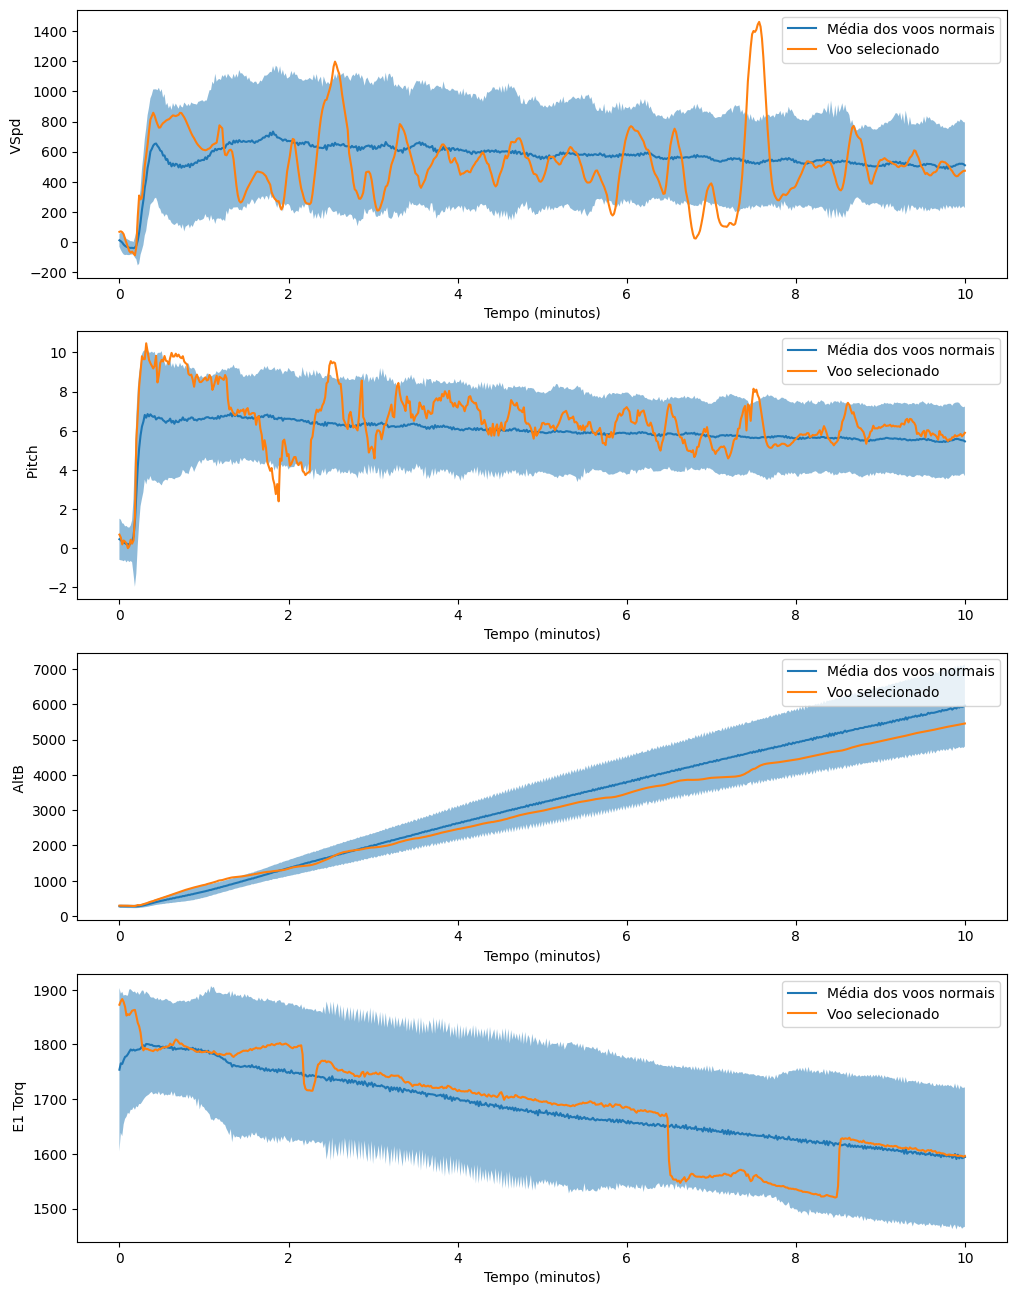

In [29]:
# Exemplo da função
graph_file_deco(lista, 'data_SBBV\log_230426_130520_SBBV.csv')

# O voo selecionado foi classificado como outlier pelo DBSCAN

## Pouso

A seguir estão os códigos adaptados para o período do pouso. A estrutura dos códigos é semelhante, alterando em geral apenas filtros para capturar os dados referentes ao pouso

In [30]:
def preprocessamento_pouso(file_path):
    ''' A função recebe o caminho de um arquivo de voo e retorna um dataframe preprocessado
        para utilizações futuras'''

    df = pd.read_csv(file_path, encoding='latin', skiprows=2)
    df.drop(columns=remove, inplace=True)
    df = df.replace(r'^\s*$', 0, regex=True) # Substitui espaços em branco por 0
    df = df.replace('  -', np.nan) # Substitui caracter invalido por nulo
    df = df.interpolate(method='linear', limit_direction='forward', axis=0).fillna(0) # Interpolação para preencher nulos
    df[' Lcl Time'] = df[' Lcl Time'].replace('', np.nan)
    df.dropna(subset=[' Lcl Time'], inplace=True)
      
    try:
        df['marcador'] = pd.to_timedelta(df[' Lcl Time'], errors='coerce')
    except ValueError as e:
        print(f"Erro ao converter para timedelta: {e}")
        print("Valores problemáticos:")
        print(df[df[' Lcl Time'].isna()][' Lcl Time'])
    df['tempo_passado'] = df['marcador'] - df['marcador'].iloc[0]
    #df = df[df['tempo_passado'] > pd.Timedelta(minutes=30)]
    df['    IAS'] = pd.to_numeric(df['    IAS'], errors='coerce')
    df = df[df['    IAS'] > 40]
    corte = df['tempo_passado'].max() - pd.Timedelta(minutes=10)
    df = df[df['tempo_passado'] >= corte]
    df.dropna(inplace=True)
    
    return df

In [31]:
def pipe_pouso(file_path):
    ''' Recebe um caminho de arquivo, realiza as operações descritas acima e retorna um 
        vetor contendo as informções do arquivo e o nome do arquivo'''

    # Carregando dados preprocessados
    df = preprocessamento_pouso(file_path)
    
    # Padronização
    scaler = StandardScaler()
    df[col_num] = scaler.fit_transform(df[col_num])

    # Binarização
    encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    encoded_features = encoder.fit_transform(df[col_bin].astype(str))
    encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(col_bin))
    df = pd.concat([df.reset_index(drop=True), encoded_df.reset_index(drop=True)], axis=1).drop(col_bin, axis=1)

    # Criação da coluna 'time' e resample
    sample_interval = '30'
    tempo = pd.to_datetime(df['  Lcl Date'] + ' ' + df[' Lcl Time'].str.slice(0, 5), 
                           format='%Y-%m-%d %H:%M', errors='coerce')
    tempo = tempo.dropna()
    df = df.select_dtypes('number')
    df['time'] = tempo
    df = df.set_index('time').resample(f'{sample_interval}S').mean().fillna(method='ffill').dropna().reset_index()
    df['time'] = df['time'] - df['time'].iloc[0]
    max = df['time'].max()
    corte = max - pd.Timedelta(minutes=10)
    # Selecionando os ultimos 10 minutos
    df = df[df['time'] >= corte]
    df.drop(columns=['marcador', 'tempo_passado'], inplace=True)

    # Vetorização do dataframe
    vetor = df.drop(columns=['time']).values.flatten()

    return vetor, file_path, df

In [32]:
def cluster_pouso(data_dir):
    ''' Recebe o nome da pasta na qual os arquivos estão armazenados e retorna um dataframe
        com as componentes principais do PCA, resultado do cluster e nome do arquivo'''
    
    # Criando listas para armazenar os vetores e nomes de arquivos
    vetores = []
    files = []

    # Aplica a função anterior e armazena os resultados para todos os arquivos
    for file_name in os.listdir(data_dir):
        if file_name.endswith('.csv'):
            file_path = os.path.join(data_dir, file_name)
            vetor, file, _ = pipe_pouso(file_path)
            vetores.append(vetor)
            files.append(file)

    # Contruindo um dataframe com os vetores de todos os arquivos e seus respectivos nomes
    df = pd.DataFrame(vetores)
    df['file'] = files

    # Remoção de valores nulos
    df_final = df
    df_final = df_final.dropna(axis=1, how='all')
    df_final.fillna(0, inplace=True)
    df_final['file'] = files

    return df_final

Carregando os dados

In [33]:
df_final = cluster_pouso('data_SBBV')

#### PCA e Clusterização

Analizando a porcentagem de explicação dos dados para diferentes números de componentes principais

In [34]:
pca = PCA().fit(df_final.drop(columns=['file']))

for i in range(1,30):
    print(f'n_comp {i}: {pca.explained_variance_ratio_[:i].sum()}')


n_comp 1: 0.22933218499545446
n_comp 2: 0.3874238104134432
n_comp 3: 0.5146066273378211
n_comp 4: 0.6208108396873073
n_comp 5: 0.6985791982859547
n_comp 6: 0.7502333015451664
n_comp 7: 0.7902780482932636
n_comp 8: 0.8236661633593436
n_comp 9: 0.8495769206454441
n_comp 10: 0.8720305630765837
n_comp 11: 0.8922742291275017
n_comp 12: 0.9104044052357073
n_comp 13: 0.9259732115014006
n_comp 14: 0.9381719863007797
n_comp 15: 0.9483058705320764
n_comp 16: 0.9573549528078776
n_comp 17: 0.9653972132965459
n_comp 18: 0.9703804735357825
n_comp 19: 0.974927259628224
n_comp 20: 0.9787423653152957
n_comp 21: 0.9815671578373981
n_comp 22: 0.9838318717415064
n_comp 23: 0.9852272150235858
n_comp 24: 0.9863576808732366
n_comp 25: 0.9873139003659257
n_comp 26: 0.9881866972462457
n_comp 27: 0.9889709535234563
n_comp 28: 0.989629398360487
n_comp 29: 0.9902246580963825


In [35]:
df_pca = PCA(n_components=11).fit_transform(df_final.drop(columns=['file']))

Criando listas com o eps da clusterização e os respectivos números de outliers e sua porcentagem

In [36]:
min_samples = 5
epss = []
pcts = []
nums = []
for eps in np.arange(5, 501, 2):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    resultado = dbscan.fit_predict(df_pca)
    resultado[resultado != 0] = -1
    pct = (np.count_nonzero(resultado == -1)/len(resultado))*100
    num = np.count_nonzero(resultado == -1)
    
    if len(set(resultado)) > 1:
        score = silhouette_score(df_pca, resultado)
        nums.append(num)
        epss.append(eps)
        pcts.append(pct)
        #print(f'eps: {eps}, voo anormal: {round(pct,2)}%, Silhouette Score: {score}')

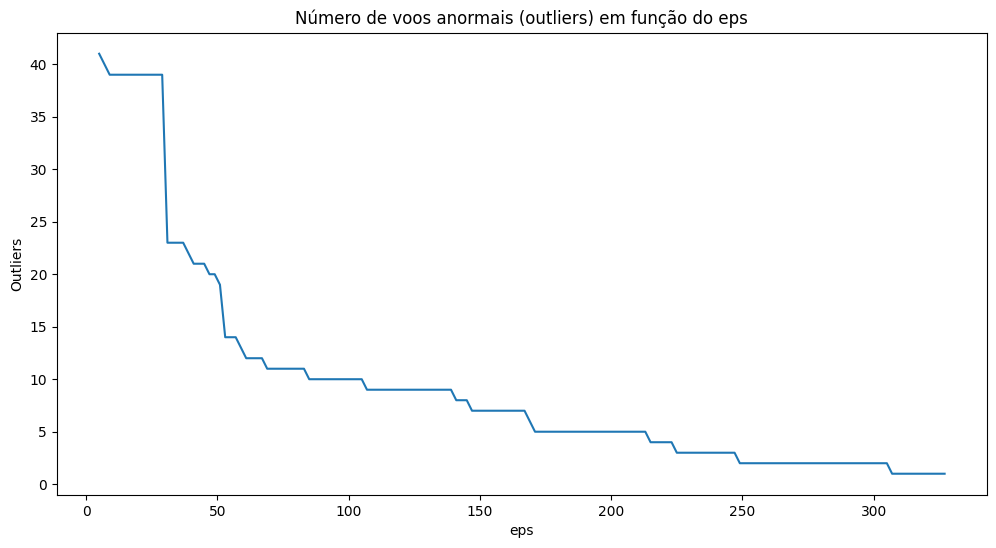

In [37]:
plt.figure(figsize=(12,6))
plt.title('Número de voos anormais (outliers) em função do eps')
sns.lineplot(x=epss, y=nums)
plt.ylabel('Outliers')
plt.xlabel('eps')
plt.show()

In [38]:
eps_outliers = pd.DataFrame()
eps_outliers['eps'] = epss
eps_outliers['pct_outliers'] = pcts
eps_outliers['pct_outliers'] = eps_outliers['pct_outliers'].apply(lambda x: round(x,2))
eps_outliers['num_outliers'] = nums

eps_outliers

eps  pct_outliers  num_outliers
0      5         18.47            41
1      7         18.02            40
2      9         17.57            39
3     11         17.57            39
4     13         17.57            39
..   ...           ...           ...
157  319          0.45             1
158  321          0.45             1
159  323          0.45             1
160  325          0.45             1
161  327          0.45             1

[162 rows x 3 columns]

In [39]:
cluster = DBSCAN(eps=150).fit(df_pca)


In [40]:
resultados_pouso = pd.DataFrame(df_pca)
resultados_pouso['cluster_pouso'] = cluster.labels_
resultados_pouso['cluster_pouso'] = resultados_pouso['cluster_pouso'].apply(lambda x: 0 if x==0 else -1)
resultados_pouso['file'] = df_final['file']

resultados_pouso.head()

0          1          2          3          4          5         6  \
0  -8.979116   3.170555   1.455266   0.815314   0.716873  -1.242926 -0.848496   
1 -92.485976  33.283216  35.568295  16.873231  31.726964 -13.714319  2.057648   
2  -8.827124   3.287439   1.281860   0.524447   1.433270  -2.046976 -0.812151   
3  51.579888 -19.898606 -29.098170 -18.517833  11.079779 -19.728643 -1.463330   
4  69.260537 -24.040200 -29.372290 -13.454604 -27.878539   9.068065 -7.165201   

           7          8          9         10  cluster_pouso  \
0   0.373019   0.723956  -1.453936  -0.740821              0   
1  38.846496  77.427019  44.767775  17.584206              0   
2   0.537682  -0.063524  -0.425980  -0.189940              0   
3  -8.513049 -12.063085  17.045219  44.208004              0   
4 -16.600703  -3.705045  85.375311 -50.522847              0   

                                   file  
0  data_SBBV\log_230419_121247_SBBV.csv  
1  data_SBBV\log_230420_062111_SBBV.csv  
2  data_SBBV\log_230420_114021_SBBV.csv  
3  data_SBBV\log_230421_104535_SBBV.csv  
4  data_SBBV\log_230424_111940_SBBV.csv

Comparando a correlação entre as variáveis dos voos antes e depois do PCA:

In [41]:
corr1 = df_final.drop(columns=['file']).corr(method='spearman')
corr2 = resultados_pouso.drop(columns=['cluster_pouso', 'file']).corr(method='spearman')

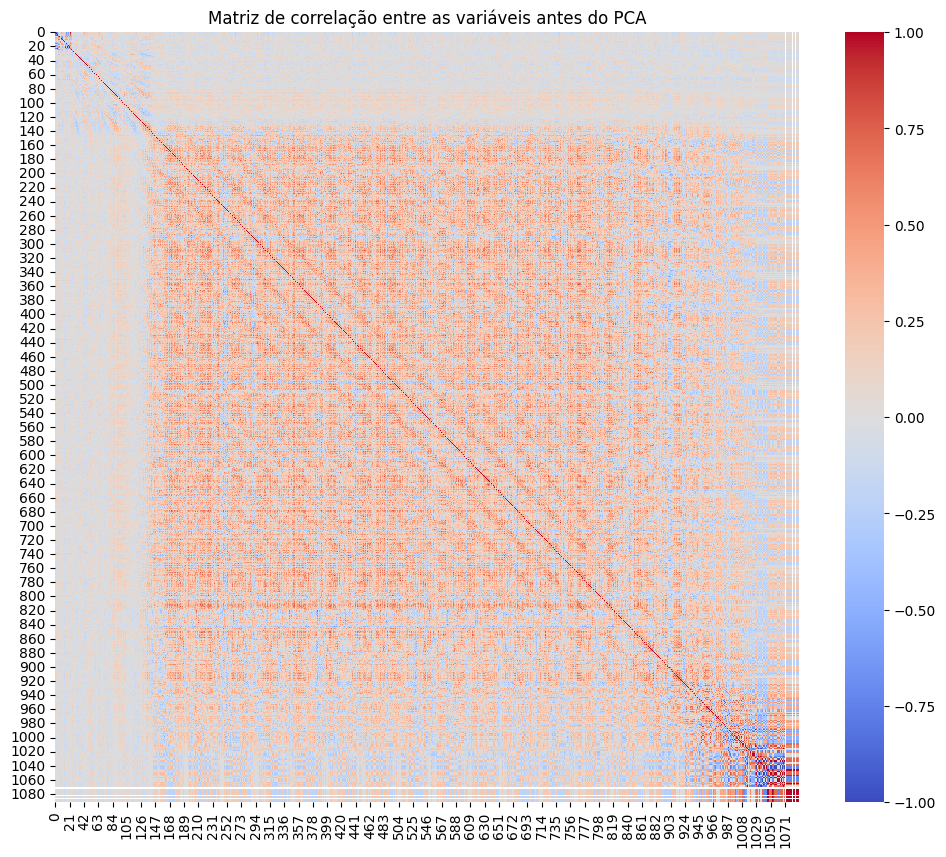

In [42]:
plt.figure(figsize=(12,10))
sns.heatmap(corr1, cmap='coolwarm')
plt.title('Matriz de correlação entre as variáveis antes do PCA')
plt.show()

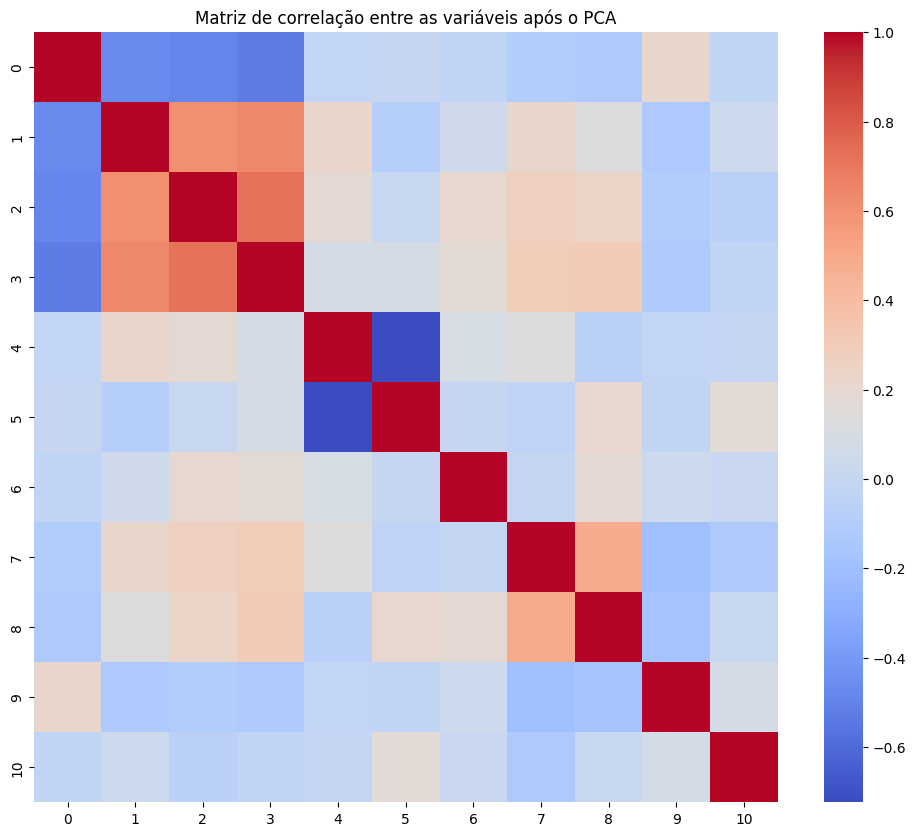

In [43]:
plt.figure(figsize=(12,10))
sns.heatmap(corr2, cmap='coolwarm')
plt.title('Matriz de correlação entre as variáveis após o PCA')
plt.show()

In [44]:
dict_resultado_pouso = resultados_pouso[['file', 'cluster_pouso']].set_index('file')['cluster_pouso'].to_dict()

resultados_pouso['cluster_pouso'].value_counts()

cluster_pouso
 0    215
-1      7
Name: count, dtype: int64

#### Gráficos - POUSO

In [45]:
def graph_file_pouso(var_list, file):
    ''' Recebe o nome de uma variável e retorna o gráfico da média da variável em função
        do tempo segmentada pelo resultado do cluster'''
    
    # Lista para armazenar os dataframes
    dfs = []

    def pre_graph(file_path, cluster):
        df = pd.read_csv(file_path, encoding='latin', skiprows=2)
        df.drop(columns=remove, inplace=True)
        df = df.replace(r'^\s*$', 0, regex=True)
        df = df.replace('  -', np.nan)
        df = df.interpolate(method='linear', limit_direction='forward', axis=0).fillna(0)
        df['    IAS'] = df['    IAS'].astype(float)
        df = df[df['    IAS'] > 40]

        df[' Lcl Time'] = df[' Lcl Time'].str.strip()
        df[' Lcl Time'] = pd.to_datetime(df[' Lcl Time'], format='%H:%M:%S', errors='coerce')
        df.dropna(inplace=True)
        df['time'] = df[' Lcl Time'] - df[' Lcl Time'].iloc[0]
        max = df['time'].max()
        corte = max - pd.Timedelta(minutes=10)
        df = df[df['time'] >= corte]
        min = df['time'].min()
        df['time'] = df['time'] - min
        df.drop(columns=[' Lcl Time', '  Lcl Date'], inplace=True)

        df['cluster'] = cluster
        
        for var in var_list:
            df[var] = df[var].astype(float)

        return df
    
    for file_path, cluster in dict_resultado_pouso.items():
        df = pre_graph(file_path, cluster)
        dfs.append(df)

    combined_df = pd.concat(dfs, ignore_index=True)
    combined_df = combined_df[combined_df['cluster'] == 0]
    df_file = pre_graph(file, -1)

    fig, axes = plt.subplots(len(var_list), 1, figsize=(12,16))

    if len(var_list) == 1:
        axes= [axes]

    for i, var in enumerate(var_list):
    
        g1 = combined_df.groupby('time')[var].agg(['mean', 'std']).reset_index()
        g2 = df_file.groupby('time')[var].mean().reset_index()
        g1['time_minutes'] = g1['time'].dt.total_seconds()/60
        g2['time_minutes'] = g2['time'].dt.total_seconds()/60


        sns.lineplot(data=g1, x='time_minutes', y='mean', ax=axes[i],
                label='Média dos voos normais')
        axes[i].fill_between(g1['time_minutes'],
                             g1['mean']-1.96*g1['std'],
                             g1['mean']+1.96*g1['std'],
                             alpha=0.5)
        sns.lineplot(data=g2, x='time_minutes', y=var, ax=axes[i],
                label='Voo selecionado')

        axes[i].set_xlabel('Tempo (minutos)')
        axes[i].set_ylabel(var)
        axes[i].legend()

    
    return plt.show()

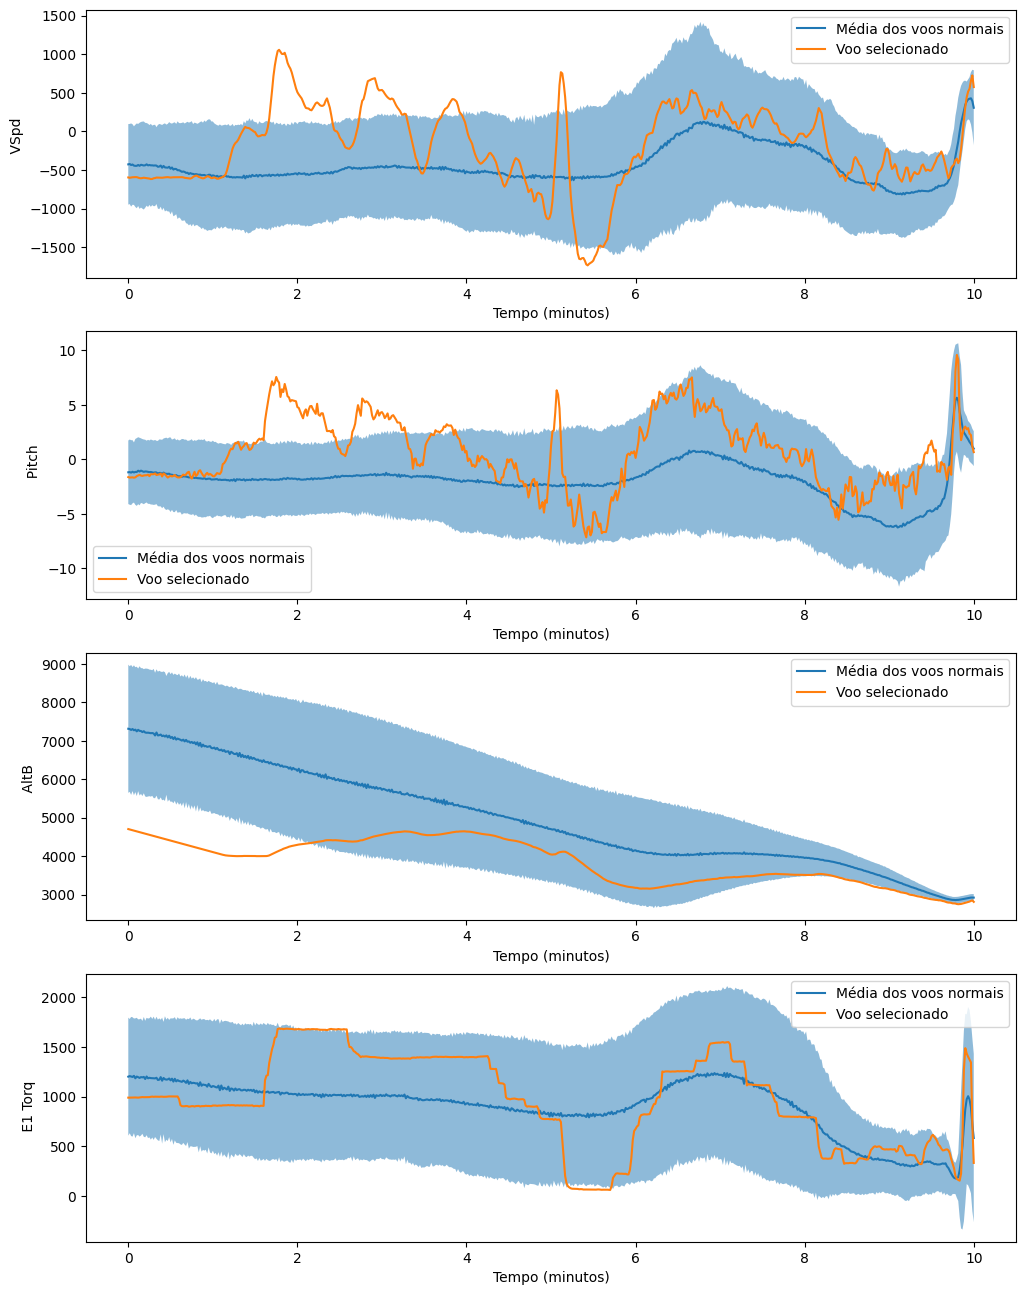

In [46]:
graph_file_pouso(lista, 'data_SBBV\log_230427_051445_SBBV.csv')

# O voo selecionado foi classificado como outlier pelo DBSCAN

Abaixo existe um código para juntar os resultados do cluster com o nome do arquivo:

#### Resultados Finais

In [47]:
# Juntando os dataframes de resultados

resultado_cluster = resultados_pouso.merge(resultados_deco,
                                            on='file', how='left')

In [48]:
# Filtrando as colunas desejadas

df_clus = resultado_cluster[['file', 'cluster_deco', 'cluster_pouso']]

In [49]:
df_clus

file  cluster_deco  cluster_pouso
0    data_SBBV\log_230419_121247_SBBV.csv             0              0
1    data_SBBV\log_230420_062111_SBBV.csv             0              0
2    data_SBBV\log_230420_114021_SBBV.csv             0              0
3    data_SBBV\log_230421_104535_SBBV.csv             0              0
4    data_SBBV\log_230424_111940_SBBV.csv             0              0
..                                    ...           ...            ...
217  data_SBBV\log_231019_110002_SBBV.csv             0              0
218  data_SBBV\log_231019_150356_SBBV.csv             0              0
219  data_SBBV\log_231020_111238_SBBV.csv             0              0
220  data_SBBV\log_231020_171902_SBBV.csv             0              0
221  data_SBBV\log_231025_121704_SBBV.csv             0              0

[222 rows x 3 columns]

In [50]:
df_clus[df_clus['cluster_pouso'] == -1]

file  cluster_deco  cluster_pouso
7    data_SBBV\log_230427_051445_SBBV.csv             0             -1
49   data_SBBV\log_230606_124421_SBBV.csv             0             -1
167  data_SBBV\log_230905_074242_SBBV.csv             0             -1
198  data_SBBV\log_231004_094920_SBBV.csv             0             -1
206  data_SBBV\log_231010_143448_SBBV.csv             0             -1
210  data_SBBV\log_231012_133421_SBBV.csv             0             -1
215  data_SBBV\log_231014_171555_SBBV.csv             0             -1

In [51]:
df_clus[df_clus['cluster_deco'] == -1]

file  cluster_deco  cluster_pouso
6    data_SBBV\log_230426_130520_SBBV.csv            -1              0
23   data_SBBV\log_230506_102059_SBBV.csv            -1              0
36   data_SBBV\log_230526_165357_SBBV.csv            -1              0
42   data_SBBV\log_230531_180650_SBBV.csv            -1              0
43   data_SBBV\log_230601_131947_SBBV.csv            -1              0
45   data_SBBV\log_230602_132246_SBBV.csv            -1              0
59   data_SBBV\log_230619_133047_SBBV.csv            -1              0
64   data_SBBV\log_230620_173546_SBBV.csv            -1              0
65   data_SBBV\log_230621_124612_SBBV.csv            -1              0
66   data_SBBV\log_230621_125716_SBBV.csv            -1              0
72   data_SBBV\log_230624_171519_SBBV.csv            -1              0
78   data_SBBV\log_230628_134155_SBBV.csv            -1              0
79   data_SBBV\log_230629_122326_SBBV.csv            -1              0
81   data_SBBV\log_230630_131845_SBBV.csv            -1              0
82   data_SBBV\log_230701_172055_SBBV.csv            -1              0
84   data_SBBV\log_230703_171811_SBBV.csv            -1              0
87   data_SBBV\log_230705_175725_SBBV.csv            -1              0
88   data_SBBV\log_230706_112115_SBBV.csv            -1              0
93   data_SBBV\log_230708_114304_SBBV.csv            -1              0
94   data_SBBV\log_230708_160941_SBBV.csv            -1              0
95   data_SBBV\log_230710_113246_SBBV.csv            -1              0
101  data_SBBV\log_230719_162214_SBBV.csv            -1              0
112  data_SBBV\log_230803_162041_SBBV.csv            -1              0
115  data_SBBV\log_230805_171509_SBBV.csv            -1              0
117  data_SBBV\log_230807_143915_SBBV.csv            -1              0
121  data_SBBV\log_230812_104642_SBBV.csv            -1              0
122  data_SBBV\log_230812_121818_SBBV.csv            -1              0
128  data_SBBV\log_230816_155623_SBBV.csv            -1              0
131  data_SBBV\log_230818_065908_SBBV.csv            -1              0
136  data_SBBV\log_230819_110446_SBBV.csv            -1              0
138  data_SBBV\log_230821_082357_SBBV.csv            -1              0
148  data_SBBV\log_230824_173418_SBBV.csv            -1              0
158  data_SBBV\log_230829_132223_SBBV.csv            -1              0
177  data_SBBV\log_230923_060903_SBBV.csv            -1              0

* Extra

Método para salvar dataframes em arquivos .csv:

Ao longo do arquivo deixei varias partes em formato de dataframe. Acredito que seja mais interessante para você ter essas informações em um arquivo csv para analisar em outros lugares como um excel por exemplo. O pandas (biblioteca que usei para manipular os dados) tem um método de salvar dataframes no formato .csv da seguinte forma:

dataframe_desejado.to_csv('nome_que_voce_deseja_salvar.csv', index=False)

isso vai gerar um csv do dataframe desejado que vai ser salvo no diretório onde este notebook está!